This is exercise to run monte carlo for portfolio constructions among M7

In [82]:
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [83]:
#setup parameters

Num_portfolio = 10 ** 5 #simulate 10^4 possible solutions
Num_days = 252 #annualize return 
Sym_list = ['AAPL','AMZN','META','GOOGL','MSFT', 'NVDA', 'TSLA']
Sym_list.sort() #yfinance return data with alphabit order, align data element accordingly

end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)


Download price history and format data frame

In [84]:
adj_close_df = pd.DataFrame()
for sym in Sym_list:
    data = yf.download(sym, start = start_date,end = end_date) #download one by one, it seems runs faster.
    adj_close_df[sym] = data['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [85]:
adj_close_df

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2019-02-15,41.015785,80.397499,55.981499,162.500000,102.765396,39.029461,20.525333
2019-02-19,41.138535,81.378998,56.325500,162.289993,102.717926,38.855827,20.375999
2019-02-20,41.403267,81.105003,56.029499,162.559998,102.183868,39.329617,20.170668
2019-02-21,41.169819,80.972000,55.210499,160.039993,104.339142,38.640018,19.415333
2019-02-22,41.629509,81.578003,55.827999,161.889999,105.826820,39.488377,19.647333
...,...,...,...,...,...,...,...
2024-02-07,189.168625,170.529999,145.539993,469.589996,414.049988,700.989990,187.580002
2024-02-08,188.080017,169.839996,145.910004,470.000000,414.109985,696.409973,189.559998
2024-02-09,188.850006,174.449997,149.000000,468.109985,420.549988,721.330017,193.570007


Calculate individual returns and covariance matrix

In [86]:
simple_returns = adj_close_df.pct_change().dropna()
simple_avg_return = simple_returns.mean() * Num_days
simple_cov_matrix = simple_returns.cov() * Num_days

Random portfolio weights for simulation

In [87]:
np.random.seed(42)
weights = np.random.random(size=(Num_portfolio, len(Sym_list))) #return random weight size=(shapelike), shapelike = [[weights] * num of portfolio]
weights /=  np.sum(weights, axis=1)[:, np.newaxis] #random weights divided by sum weight to become partial of the total random weight


Get risk free rate from fred

In [88]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [89]:


from fredapi import Fred

filename = 'apikey'
api_key = get_file_contents(filename)
fred = Fred(api_key=api_key) 
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
print(risk_free_rate)

0.0406


Calculate portfolio returns

In [90]:
portf_rtns = np.dot(weights, simple_avg_return)
portf_vol = list()
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(simple_cov_matrix, weights[i]))
    )    
    portf_vol.append(vol)

portf_vol = np.array(portf_vol)
portf_sharpe_ratio = (portf_rtns - risk_free_rate)/ portf_vol


Format data frame

In [91]:
portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)
portf_results_df

,returns,volatility,sharpe_ratio
0,0.295106,0.307721,0.827067
1,0.393124,0.313587,1.124167
2,0.428024,0.349596,1.108204
3,0.388360,0.326600,1.064789
4,0.513766,0.382034,1.238542
...,...,...,...
99995,0.443759,0.337308,1.195225
99996,0.373238,0.336912,0.987314
99997,0.382163,0.323240,1.056685
99998,0.375701,0.336677,0.995321


Locate points of efficient frontier:

In [92]:
N_POINTS = 100
ef_rtn_list = []
ef_vol_list = []
possible_ef_rtns = np.linspace(portf_results_df["returns"].min(),
                               portf_results_df["returns"].max(),
                               N_POINTS)
possible_ef_rtns = np.round(possible_ef_rtns, 2)
portf_rtns = np.round(portf_rtns, 2)

for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))
        

Plot efficient frontier

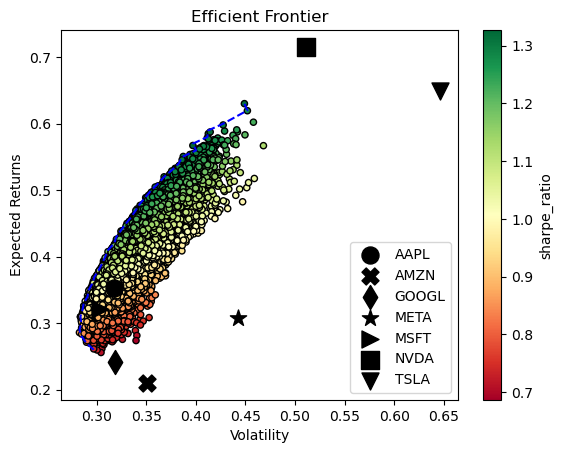

In [93]:
import matplotlib.pyplot as plt

MARKERS = ["o", "X", "d", "*",">","s","v"]
fig, ax = plt.subplots()
portf_results_df.plot(kind="scatter", x="volatility",
                      y="returns", c="sharpe_ratio",
                      cmap="RdYlGn", edgecolors="black",
                      ax=ax)

ax.set(xlabel="Volatility",
       ylabel="Expected Returns",
       title="Efficient Frontier")
ax.plot(ef_vol_list, ef_rtn_list, "b--")

for asset_index in range(len(Sym_list)):
    ax.scatter(x=np.sqrt(simple_cov_matrix.iloc[asset_index, asset_index]),
               y=simple_avg_return[asset_index], marker=MARKERS[asset_index], s=150, color="black", label=Sym_list[asset_index])


ax.legend()
plt.show()

Maximum Sharpe ratio and Minimum Volatility portfolios

In [94]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"]) #index of max sharpe ratio portfolio
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df["volatility"]) #index of min volatility portfolio
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [95]:
print("Max Sharpe Ratio portfolio")
print(max_sharpe_portf)

print( [{'Sym': Sym, 'weight': weight} for Sym, weight in zip(Sym_list, weights[max_sharpe_ind])])


print("Minimum Volatility portfolio")
print(min_vol_portf)
print( [{'Sym': Sym, 'weight': weight} for Sym, weight in zip(Sym_list, weights[min_vol_ind])])


Max Sharpe Ratio portfolio
returns         0.567254
volatility      0.396972
sharpe_ratio    1.326679
Name: 75071, dtype: float64
[{'Sym': 'AAPL', 'weight': 0.30158708477426865}, {'Sym': 'AMZN', 'weight': 0.007147430041333554}, {'Sym': 'GOOGL', 'weight': 0.014451248307263196}, {'Sym': 'META', 'weight': 0.01868421354701967}, {'Sym': 'MSFT', 'weight': 0.017389723671560116}, {'Sym': 'NVDA', 'weight': 0.4302969104343323}, {'Sym': 'TSLA', 'weight': 0.21044338922422254}]
Minimum Volatility portfolio
returns         0.285984
volatility      0.282608
sharpe_ratio    0.868282
Name: 60667, dtype: float64
[{'Sym': 'AAPL', 'weight': 0.23132840378521838}, {'Sym': 'AMZN', 'weight': 0.17523587795474901}, {'Sym': 'GOOGL', 'weight': 0.3351108226007163}, {'Sym': 'META', 'weight': 0.004519707897697318}, {'Sym': 'MSFT', 'weight': 0.2449529581869061}, {'Sym': 'NVDA', 'weight': 0.007120247571833608}, {'Sym': 'TSLA', 'weight': 0.0017319820028792693}]


Show portoflios in the chart

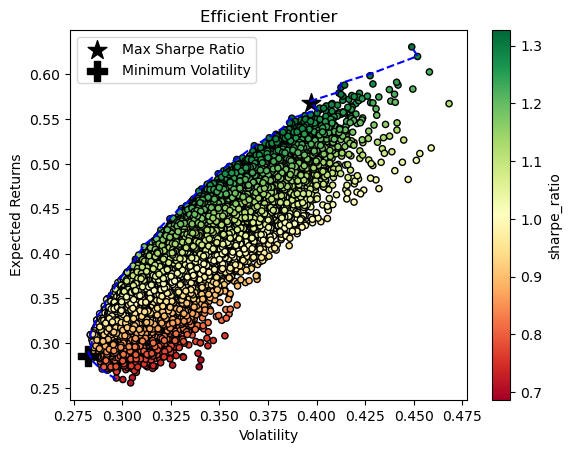

In [96]:
fig, ax = plt.subplots()
portf_results_df.plot(kind="scatter", x="volatility",
                      y="returns", c="sharpe_ratio",
                      cmap="RdYlGn", edgecolors="black",
                      ax=ax)

ax.scatter(x=max_sharpe_portf["volatility"],
           y=max_sharpe_portf["returns"],
           c="black", marker="*",
           s=200, label="Max Sharpe Ratio")
ax.scatter(x=min_vol_portf["volatility"],
           y=min_vol_portf["returns"],
           c="black", marker="P",
           s=200, label="Minimum Volatility")

ax.set(xlabel="Volatility",
       ylabel="Expected Returns",
       title="Efficient Frontier")
ax.plot(ef_vol_list, ef_rtn_list, "b--")


ax.legend()
plt.show()